# Problem Set 9_Kaiyue Wu

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import norm
import scipy.stats
from scipy.stats import ncx2
import math
from scipy.optimize import newton
from scipy.optimize import fsolve

new_line = '\n'
pd.options.mode.chained_assignment = None 
import warnings
warnings.filterwarnings('ignore')

sns.set(font_scale=1.5, rc={'text.usetex' : True,})
%config InlineBackend.figure_format='retina'

**Consider a 30-year MBS with a fixed WAC = 8% (monthly cash flows starting in January
of this year). The Notional Amount of the Loan is 100,000.Use the CIR model of interest rates:**

$dr = \kappa(\bar{r}-r)dt + \sigma\sqrt{r}dW$

with $r = 0.078, k =0.6,\bar{r}=0.08,\sigma = 0.12 $

**Consider the Numerix Prepayment Model in all problems below.**


In [2]:
r0 = 0.078
kappa = 0.6
r_bar = 0.08
sigma = 0.12
year = 30
WAC = 0.08
NotionalAmt = 100000

In [3]:
def CIR_R(path,r0,T,t,r_bar):
    
    np.random.seed(0)
    
    dt = 1/120
    steps = int(round(T/dt))
    r = np.zeros((path,steps+1))
    r[:,0] = r0
    
    for i in range(1,steps+1):
        dWt = np.sqrt(dt)*np.random.normal(0,1,path)
        r[:,i] = r[:,i-1] + kappa*(r_bar - r[:,i-1])*dt + sigma*np.sqrt(np.abs(r[:,i-1]))*dWt
        
    return r

In [4]:
def RF_10(kappa,sigma,r_bar,T,t,rt):
    
    T = 10
    t = 0
    h1 = np.sqrt(kappa**2 + 2*sigma**2)
    h2 = (kappa + h1)/2
    h3 = (2*kappa*r_bar)/sigma**2
    
    A = ((h1 * np.exp(h2*(T - t)))/(h2 * (np.exp(h1*(T - t)) - 1) + h1))**h3
    B = (np.exp(h1*(T - t)) - 1)/(h2 * (np.exp(h1*(T - t)) - 1) + h1)
    
    r_tminus1_10 = -np.log(A*np.exp(-B*rt))/(T - t)
    
#     r_tminus1_10 = np.vectorize(r_tminus1_10)
    return r_tminus1_10

In [5]:
def SY(t):
    
    t = int(t%12)
    SYt = np.array([0.94, 0.76, 0.74, 0.95, 0.98, 0.92, 0.98, 1.10, 1.18, 1.22, 1.23, 0.98])
    
    return SYt[t]
    
def CPR(kappa, sigma, r_bar, T, t, rt,R,PV_tminus1,PV0,SY):
    r_tminus1_10 = RF_10(kappa, sigma, r_bar, T, t, rt)
    RIt = 0.28 + 0.14*np.arctan(-8.57 + 430*(R - r_tminus1_10))
    BUt = 0.3 + 0.7*PV_tminus1/PV0
    SGt = min(1,t/30)
    SYt = SY
    
    return RIt * BUt * SGt * SYt

In [6]:
def IP(PV_tminus1,r):
    
    IPt = PV_tminus1*r
    
    return IPt
    
def SMM(CPR):
    
    SMMt = 1-(1-CPR)**(1/12)
    
    return SMMt

def MP(PV_tminus1,r,N,t):
    
    temp = 1/((1+r)**(N-t+1))
    
    MPt = PV_tminus1 * r / (1-temp)
    
    return MPt

def SP(MPt,IPt):
    
    SPt = MPt - IPt
    
    return SPt
def PP(PV_tminus1,SPt,SMMt):
    
    PPt = (PV_tminus1 - SPt)*SMMt
    
    return PPt

In [7]:
def MBS(r0,kappa,r_bar,sigma,T,WAC,NotionalAmt,t,path):
    
    np.random.seed(0)
    
    dt = 1/120
    N = 12*year
    steps = int(round(T/dt))
    r = WAC/12

    rt = CIR_R(path=path,r0=r0,T=T,t=t,r_bar=r_bar)
#     r_tminus1_10 = RF_10(kappa=kappa, sigma=sigma, r_bar=r_bar, T=T, t=t, rt=rt)
    
    PV = np.zeros((path,N))
    R = np.zeros((path,N))
    PV[:,0] = NotionalAmt
    ct = np.zeros((path,N))
    
    for i in range(N):
        R[:,i] =  np.sum(rt[:,1:(10*i + 11)],axis=1) * dt
        r_tmin1 = rt[:, 10 * i]
        SYt = SY(i)
        PV_tminus1 = PV[:,i]
        CPRt = CPR(kappa=kappa, sigma=sigma, r_bar=r_bar, T=T, t=i, rt=r_tmin1,R=WAC,PV_tminus1=PV_tminus1,PV0=NotionalAmt,SY=SYt)
        
        MPt = MP(PV_tminus1=PV_tminus1,r=r,N=N,t=i)
        IPt = IP(PV_tminus1,r)
        SPt = SP(MPt,IPt)
        SMMt = SMM(CPRt)
        PPt = PP(PV_tminus1,SPt,SMMt)
        
        ct[:,i] = MPt + PPt
        
        TPPt = SPt + PPt
        
        if i < (N-1):
            PV[:, i+1] = PV[:,i] - TPPt
    
    disc = np.exp(-R)
    
    price = np.sum(np.multiply(disc, ct), axis=1)
    price = np.mean(price)
    
    
    return price

In [8]:
MBS(r0=0.078,kappa=0.6,r_bar=0.08,sigma=0.12,T=30,WAC=0.08,NotionalAmt=100000,t=0,path=1000)

100418.36488096791

## 1.

### (a) Compute the price of the MBS. The code should be generic: the user is prompted for inputs and the program runs and gives the output.


In [9]:
MBS_Price = MBS(r0=0.078,kappa=0.6,r_bar=0.08,sigma=0.12,T=30,WAC=0.08,NotionalAmt=100000,t=0,path=1000)

In [10]:
print(f"The MBS price is {round(MBS_Price,4)}")

The MBS price is 100418.3649


### (b) Compute the price of the MBS for the following ranges of the parameters: k in 0.3 to 0.9 (in increments of 0.1) and draw the graph of the price of MBS vs. k.


In [11]:
ks  = np.array([0.3 + 0.1*i for i in range(7)])
MBS_kappa = [MBS(r0=0.078,kappa=i,r_bar=0.08,sigma=0.12,T=30,WAC=0.08,NotionalAmt=100000,t=0,path=1000) for i in ks]

In [26]:
pd.DataFrame(list(zip(ks,MBS_kappa)),columns=['k','MBS'])

,k,MBS
0,0.3,100191.332559
1,0.4,100349.936148
2,0.5,100396.196404
3,0.6,100418.364881
4,0.7,100431.673114
5,0.8,100440.626103
6,0.9,100447.093347


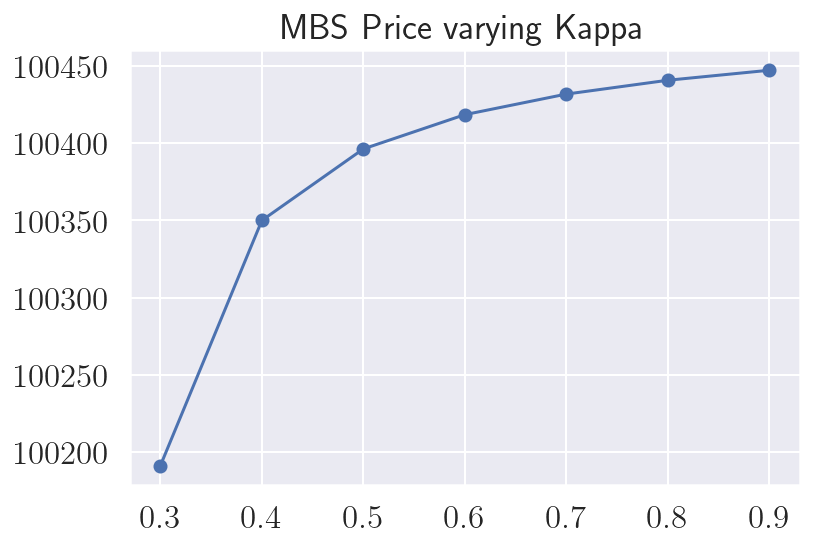

In [12]:
plt.figure()

plt.plot(ks,MBS_kappa,marker='o')
plt.xticks(ks)
plt.title("MBS Price varying Kappa")

plt.show()

### Compute the price of the MBS for the following ranges of the parameters: 𝑟̅ in 0.03 to 0.09 (in increments of 0.01) and draw the graph of MBS vs. 𝑟̅.

In [13]:
r_bars =  np.array([0.03 + 0.01*i for i in range(7)])

MBS_rbar = [MBS(r0=0.078,kappa=0.6,r_bar=i,sigma=0.12,T=30,WAC=0.08,NotionalAmt=100000,t=0,path=1000) for i in r_bars]

In [29]:
pd.DataFrame(list(zip(r_bars,MBS_rbar)),columns=['r_bar','MBS'])

,r_bar,MBS
0,0.03,111582.879995
1,0.04,109111.603774
2,0.05,106865.303909
3,0.06,105571.417424
4,0.07,105218.926582
5,0.08,100418.364881
6,0.09,95258.401828


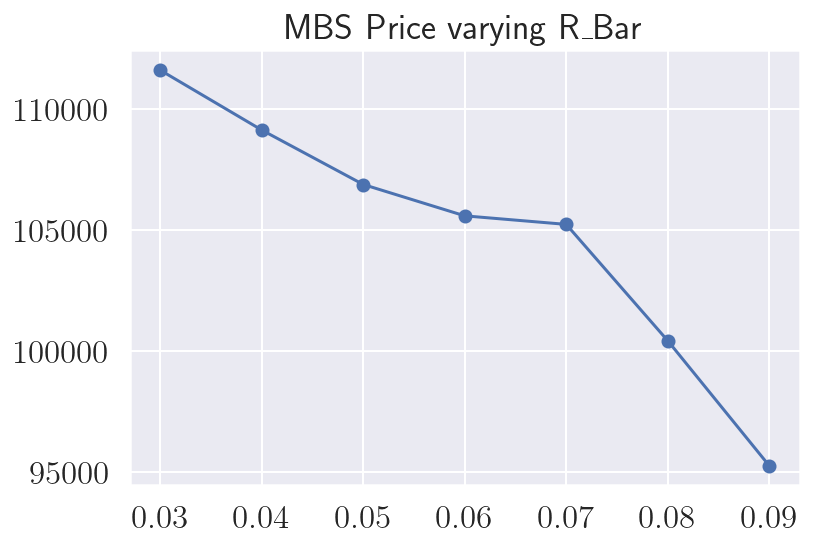

In [14]:
plt.figure()

plt.plot(r_bars,MBS_rbar,marker='o')
plt.xticks(r_bars)
plt.title("MBS Price varying R_Bar")

plt.show()

## 2. Compute the Option-Adjusted-Spread (OAS) if the Market Price of MBS is $102,000.

In [15]:
def MBS_OAS(r0,kappa,r_bar,sigma,T,WAC,NotionalAmt,t,path,marketprice):
    
    dt = 1/120
    N = 12*year
    steps = int(round(T/dt))
    r = WAC/12

    rt = CIR_R(path=path,r0=r0,T=T,t=t,r_bar=r_bar)
#     r_tminus1_10 = RF_10(kappa=kappa, sigma=sigma, r_bar=r_bar, T=T, t=t, rt=rt)
    
    PV = np.zeros((path,N))
    R = np.zeros((path,N))
    PV[:,0] = NotionalAmt
    ct = np.zeros((path,N))
    idx = np.zeros((path, N))
    
    for i in range(N):
        R[:,i] = np.sum(-rt[:,1:(12*i + 13)],axis=1) * dt
        r_tmin1 = rt[:, 10 * i]
        SYt = SY(i)
        PV_tminus1 = PV[:,i]
        CPRt = CPR(kappa=kappa, sigma=sigma, r_bar=r_bar, T=T, t=i, rt=r_tmin1,R=WAC,PV_tminus1=PV_tminus1,PV0=NotionalAmt,SY=SYt)
        
        MPt = MP(PV_tminus1=PV_tminus1,r=r,N=N,t=i)
        IPt = IP(PV_tminus1,r)
        SPt = SP(MPt,IPt)
        SMMt = SMM(CPRt)
        PPt = PP(PV_tminus1,SPt,SMMt)
        
        ct[:,i] = MPt + PPt
        
        TPPt = SPt + PPt
        
        idx[:, i] = i
        
        if i < (N-1):
            PV[:, i+1] = PV_tminus1 - TPPt
    
    disc = np.exp(R)
    
    fx = lambda x: np.mean(np.sum(np.multiply(np.exp(R - idx*x*10*dt), ct), axis=1)) - marketprice
    oas = fsolve(fx, 0)
    return oas[0]
   

In [16]:
marketprice = 102000

q2 = MBS_OAS(r0=0.078,kappa=0.6,r_bar=0.08,sigma=0.12,T=30,WAC=0.08,NotionalAmt=100000,t=0,path=1000,marketprice = 102000)

In [17]:
print(f"The Option-Adjusted-Spread (OAS) if the Market Price of MBS is $102,000 is {q2} ")

The Option-Adjusted-Spread (OAS) if the Market Price of MBS is $102,000 is -0.0176040178901824 


## 3. Compute the OAS-Adjusted Duration and Convexity of the MBS, considered in the previous question.

In [18]:
epsilon = 0.0005

def OAS_DC(r0,kappa,r_bar,sigma,T,WAC,NotionalAmt,t,path,marketprice):
    
    dt = 1/120
    N = 12*year
    steps = int(round(T/dt))
    r = WAC/12

    rt = CIR_R(path=path,r0=r0,T=T,t=t,r_bar=r_bar)
#     r_tminus1_10 = RF_10(kappa=kappa, sigma=sigma, r_bar=r_bar, T=T, t=t, rt=rt)
    
    PV = np.zeros((path,N))
    R = np.zeros((path,N))
    PV[:,0] = NotionalAmt
    ct = np.zeros((path,N))
    idx = np.zeros((path, N))
    
    for i in range(N):
        R[:,i] = np.sum(-rt[:,1:(12*i + 13)],axis=1) * dt
        r_tmin1 = rt[:, 10 * i]
        SYt = SY(i)
        PV_tminus1 = PV[:,i]
        CPRt = CPR(kappa=kappa, sigma=sigma, r_bar=r_bar, T=T, t=i, rt=r_tmin1,R=WAC,PV_tminus1=PV_tminus1,PV0=NotionalAmt,SY=SYt)
        
        MPt = MP(PV_tminus1=PV_tminus1,r=r,N=N,t=i)
        IPt = IP(PV_tminus1,r)
        SPt = SP(MPt,IPt)
        SMMt = SMM(CPRt)
        PPt = PP(PV_tminus1,SPt,SMMt)
        
        ct[:,i] = MPt + PPt
        
        TPPt = SPt + PPt
        
        idx[:, i] = i
        
        if i < (N-1):
            PV[:, i+1] = PV_tminus1 - TPPt
    
    disc = np.exp(R)
    fx = lambda x: np.mean(np.sum(np.multiply(np.exp(R - idx*x*10*dt), ct), axis=1)) - marketprice
    oas = fsolve(fx, 0)
    
    epsilon = 0.0005
    
    P0 = marketprice
    P_plus = np.mean(np.sum(np.multiply(np.exp(R - idx*(oas+epsilon)*10*dt), ct), axis=1))
    P_minus = np.mean(np.sum(np.multiply(np.exp(R - idx*(oas-epsilon)*10*dt), ct), axis=1))
    
    return P0, P_plus, P_minus
    
   

In [19]:
def OAS_duration(P_plus, P_minus, P0):
    epsilon = 0.0005
    duration = (P_minus - P_plus)/(2 * epsilon * P0)
    
    return duration

def OAS_convexity(P_plus, P_minus, P0):
    epsilon = 0.0005
    convexity = (P_minus + P_plus - 2*P0)/(2 * epsilon **2 * P0)
    
    return convexity

In [20]:
P0, P_plus, P_minus = OAS_DC(r0=0.078,kappa=0.6,r_bar=0.08,sigma=0.12,T=30,WAC=0.08,NotionalAmt=100000,t=0,path=1000,marketprice = 102000)
durationOAS = OAS_duration(P_plus, P_minus, P0)
convexityOAS = OAS_convexity(P_plus, P_minus, P0)
print("The OAS-duration is : ", durationOAS)
print("The OAS-convexity is : ", convexityOAS)

The OAS-duration is :  6.84137682620905
The OAS-convexity is :  42.3203787769821


## 4. Consider the MBS described above and the IO and PO tranches. Price the IO and PO tranches for: 𝑟̅ in 0.03 to 0.09 range, in increments of 0.01.

In [21]:
def MBS_IO_PO(r0,kappa,r_bar,sigma,T,WAC,NotionalAmt,t,path,marketprice):
    
    dt = 1/120
    N = 12*year
    steps = int(round(T/dt))
    r = WAC/12

    rt = CIR_R(path=path,r0=r0,T=T,t=t,r_bar = r_bar)
#     r_tminus1_10 = RF_10(kappa=kappa, sigma=sigma, r_bar=r_bar, T=T, t=t, rt=rt)
    
    PV = np.zeros((path,N))
    R = np.zeros((path,N))
    PV[:,0] = NotionalAmt
    ct = np.zeros((path,N))
    idx = np.zeros((path, N))
    
    Interest = np.zeros((path, N))
    Principal = np.zeros((path, N))
    
    for i in range(N):
        R[:,i] = np.sum(-rt[:,1:(12*i + 13)],axis=1) * dt
        r_tmin1 = rt[:, 10 * i]
        SYt = SY(i)
        PV_tminus1 = PV[:,i]
        CPRt = CPR(kappa=kappa, sigma=sigma, r_bar=r_bar, T=T, t=i, rt=r_tmin1,R=WAC,PV_tminus1=PV_tminus1,PV0=NotionalAmt,SY=SYt)
        
        MPt = MP(PV_tminus1=PV_tminus1,r=r,N=N,t=i)
        IPt = IP(PV_tminus1,r)
        SPt = SP(MPt,IPt)
        SMMt = SMM(CPRt)
        PPt = PP(PV_tminus1,SPt,SMMt)
        
        ct[:,i] = MPt + PPt
        
        TPPt = TPP_i = ct[:, i]-PV[:,i]*r
        
        idx[:, i] = i
        
        Interest[:, i] = PV[:,i] * r
        Principal[:, i] =  TPPt
        
        if i < (N-1):
            PV[:, i+1] = PV_tminus1 - TPPt
    
    disc = np.exp(R)
    
    IO = np.mean(np.sum(np.multiply(disc, Interest), axis = 1))
    PO = np.mean(np.sum(np.multiply(disc, Principal), axis = 1))
    
    return IO,PO
   

In [22]:
r_bar2 = np.arange(0.03, 0.091, 0.01)

IOs = np.array([MBS_IO_PO(r0=0.078,kappa=0.6,r_bar=i,sigma=0.12,T=30,WAC=0.08,NotionalAmt=100000,t=0,path=1000,marketprice = 102000)[0] for i in r_bar2])
POs = np.array([MBS_IO_PO(r0=0.078,kappa=0.6,r_bar=i,sigma=0.12,T=30,WAC=0.08,NotionalAmt=100000,t=0,path=1000,marketprice = 102000)[1] for i in r_bar2])

In [24]:
pd.DataFrame(list(zip(IOs,POs)),columns=['IO','PO'],index=r_bar2)

,IO,PO
0.03,27085.580525,81797.567105
0.04,26562.817583,79306.232131
0.05,26726.959849,76348.771876
0.06,32665.892997,67834.302390
0.07,47600.633923,49178.500863
0.08,49083.162065,41848.669334
0.09,47577.613326,37895.204394


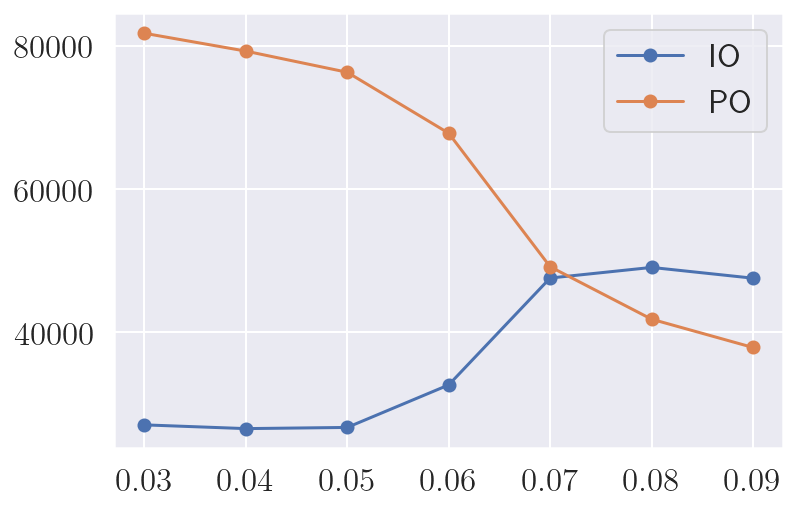

In [23]:
plt.figure()

plt.plot(r_bar2,IOs,marker='o')
plt.plot(r_bar2,POs,marker='o')
plt.xticks(r_bar2)
plt.legend(['IO','PO'])


plt.show()